In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import scipy as osp

import paragami

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import log_phi_lib, cluster_quantities_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

from structure_vb_lib import structure_model_lib, posterior_quantities_lib
from structure_vb_lib.data_utils import cluster_admix_get_indx

import re

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
data_file='../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
out_filename='huang2011_fit'
out_folder='../fits/hgdp_fits/'

# data_file = '../data/huang2011_sub_nobs25_nloci75.npz'
# out_filename = 'huang2011_fit_sub'
# out_folder = '../fits/tmp/'


In [4]:
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# Load data

In [5]:
print(data_file)

../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz


In [6]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

# Load initial fit

In [7]:
print(init_fit_file)

../fits/hgdp_fits/huang2011_fit_alpha6.0.npz


In [8]:
vb_init_dict, vb_params_paragami, _, _, \
    gh_loc, gh_weights, init_fit_meta_data = \
        structure_model_lib.load_structure_fit(init_fit_file)

In [9]:
vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)

# Function to load vb parameters

Loads parameters from both refit and LR

In [10]:
def get_free_param_array(perturbation):     
    
    #################
    # load linear response derivatives
    #################
    # print('loading derivatives from: ', lr_file)
    lr_data = np.load(lr_file)
    assert lr_data['alpha0'] == alpha0
    assert np.abs(lr_data['vb_opt'] - vb_init_free).max() < 1e-12
    assert np.abs(lr_data['kl'] - init_fit_meta_data['final_kl']) < 1e-8
    
    print('Derivative time: {:.3f}secs'.format(lr_data['lr_time_' + perturbation]))
    print('CG tolerance: ', lr_data['cg_tol'])
    
    ##################
    # load refit results
    ##################
    # get all files for that particular perturbation
    match_crit = out_filename + '_' + perturbation + '\d+.npz'
    refit_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    
    assert len(refit_files) > 0, 'no refit files found'
    
    # load files
    optim_time_vec = [init_fit_meta_data['optim_time']]
    epsilon_vec = [0.]
    vb_refit_list = [vb_init_free]
    delta_vec = []

    for i in range(len(refit_files)): 

        # print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(out_folder + refit_files[i])
        
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
        delta_vec.append(meta_data['delta'])
    
    delta = np.unique(np.array(delta_vec))
    # print('perturbation scaling (delta): ', delta)
    assert len(delta) == 1
    
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    optim_time_vec = optim_time_vec[_indx]
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    print('Optim time at epsilon = 1: {:.3f}secs'.format(optim_time_vec[-1]))
    
    ###############
    # get linear response predictions 
    ###############
    def predict_opt_par_from_hyper_par(epsilon): 
        return vb_init_free + lr_data['dinput_dfun_' + perturbation] * epsilon * delta
    
    lr_list = []
    for epsilon in epsilon_vec: 
        # get linear response
        lr_list.append(predict_opt_par_from_hyper_par(epsilon))
    
    return vb_refit_list, np.array(lr_list), epsilon_vec

# Functions to make plots

In [11]:
def print_diff_plot(refit, lr, init, title = ''): 
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 4)) 

    diff_refit = refit - init
    diff_lr = lr - init
        
    ax[0].plot(diff_refit, 
               diff_lr, 
               'o', 
               color = 'red', 
               alpha = 0.05)   
    ax[0].set_xlabel('refit - init')
    ax[0].set_ylabel('lr - init')   
    # x = y line
    ax[0].plot(diff_refit, diff_refit, '-', color = 'blue')
    ax[0].set_title(title)
    
    # compute some statistics for the diff plot
    # this is hacky ... replace with ax.table at some point
    
    # Hide axes
    ax[1].xaxis.set_visible(False) 
    ax[1].yaxis.set_visible(False)
    
    # mae 
    mean_ae = np.abs(refit - lr).mean()
    med_ae = np.median(np.abs(refit - lr))
    ax[1].text(0.05, 0.9, 
               'mean absolute error: {:.03f}'.format(mean_ae),
               fontsize=15)
    ax[1].text(0.05, 0.8, 
               'median absolute error: {:.03f}'.format(med_ae),
               fontsize=15)
    
    # R2 
    r_value = osp.stats.linregress(diff_refit,
                                   diff_lr).rvalue
    
    my_filter = (np.abs(diff_lr) < diff_refit.max()) & \
                    (np.abs(diff_lr) > diff_refit.min()) 
    r_value_filtered = osp.stats.linregress(diff_refit[my_filter],
                                            diff_lr[my_filter]).rvalue
    ax[1].text(0.05, 0.7, 
               'R2: {:.03f}'.format(r_value),
               fontsize=15)
    ax[1].text(0.05, 0.6, 
               'R2 (filtered): {:.03f}'.format(r_value_filtered),
               fontsize=15)
    # proportion that had the correct sign 
    sign_correct = np.mean(np.sign(diff_refit) == np.sign(diff_lr))
    ax[1].text(0.05, 0.5, 
               'propn sign correct:  {:.03f}'.format(sign_correct),
               fontsize=15)

### Function to plot PCA centroids

In [70]:
def plot_centroid_path(vb_refit_list, lr_list, pca_model): 
    
    fig, ax = plt.subplots(4, 5, figsize = (12, 10))
    
    def get_centroid_array(param_list): 
        centroid_array = []
        for params in param_list: 
            e_pop_freq = get_e_pop_freq(params)
            e_pop_freq_trans = pca_model.transform(e_pop_freq.transpose())
            
            centroid_array.append(e_pop_freq_trans)
            
        return np.array(centroid_array)
    
    centroids_refit = get_centroid_array(vb_refit_list)
    centroids_lr = get_centroid_array(lr_list)
       
    k_approx = centroids_refit.shape[0]

    for k in range(k_approx): 
        x0 = k // 5
        x1 = k % 5

        ax[x0, x1].plot(centroids_refit[:, k, 0], 
                        centroids_refit[:, k, 1], 
                        '-x', 
                        color = '#d95f02', 
                        label = 'refit')

        ax[x0, x1].plot(centroids_lr[:, k, 0], 
                        centroids_lr[:, k, 1], 
                        '-x', 
                        color = '#1b9e77', 
                        label = 'lr')

        ax[x0, x1].set_title('k = {}'.format(k))
        ax[x0, x1].set_ylabel('PC2')
        ax[x0, x1].set_xlabel('PC1')
        ax[x0, x1].set_xticks([])
        ax[x0, x1].set_yticks([])
    ax[0, 0].legend()
    fig.tight_layout();

### plot cosine similarities

In [71]:
def get_e_pop_freq(vb_free_params): 
    
    # this returns the expected population frequencies. 
        
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    beta_params = vb_params_dict['pop_freq_beta_params']
    
    return beta_params[:, :, 0] / (beta_params[:, :, 0] + beta_params[:, :, 1])

In [72]:
def get_cosine_sim_from_vb_free(e_pop_freq): 
        
    e_pop_freq -= e_pop_freq.mean(1, keepdims = True)
    
    # compute cosine similarity
    norm_const = np.sqrt(np.sum(e_pop_freq**2, axis = 0, keepdims = True))
    
    e_pop_freq = (e_pop_freq / norm_const)
    
    return np.dot(e_pop_freq.transpose(), e_pop_freq)

In [73]:
def plot_cosine_sim(e_pop_freq_refit, e_pop_freq_lr, e_pop_freq_init): 
    
    # get cosine similarities
    cos_sim_init = get_cosine_sim_from_vb_free(e_pop_freq_init)
    cos_sim_refit = get_cosine_sim_from_vb_free(e_pop_freq_refit)
    cos_sim_lr = get_cosine_sim_from_vb_free(e_pop_freq_lr)
    
    fig, ax = plt.subplots(1, 3, figsize = (12, 3))

    # plot cosine similarity
    ax[0].set_title('initial')
    im0 = ax[0].matshow(cos_sim_init, 
                        cmap = plt.get_cmap('Blues'))
    fig.colorbar(im0, ax = ax[0])
    
    # plot differences
    diff_refit = cos_sim_refit - cos_sim_init
    diff_lr = cos_sim_lr - cos_sim_init
    
    vmax = max(np.abs(diff_refit).max(), np.abs(diff_lr).max())
    
    ax[1].set_title('refit - init')
    im1 = ax[1].matshow(diff_refit, 
                        vmax = vmax,
                        vmin = -vmax, 
                        cmap = plt.get_cmap('bwr'))
    fig.colorbar(im1, ax = ax[1])
    
    ax[2].set_title('lr - init')
    im2 = ax[2].matshow(diff_lr, 
                        vmax = vmax,
                        vmin = -vmax, 
                        cmap = plt.get_cmap('bwr'))
    fig.colorbar(im2, ax = ax[2])
    
    for a in ax: 
        a.xaxis.set_ticks_position('bottom')
        
    return cos_sim_refit, cos_sim_lr, cos_sim_init

### Function to plot all results

In [74]:
from sklearn import decomposition

In [75]:
def plot_results_for_perturbation(perturbation): 
    #################
    # load free parameters
    #################
    vb_refit_list, lr_list, epsilon_vec = \
        get_free_param_array(perturbation)
    
    #################
    # compute expected population frequencies
    #################
    e_pop_freq_init = get_e_pop_freq(vb_init_free)
    e_pop_freq_refit  = get_e_pop_freq(vb_refit_list[-1])
    e_pop_freq_lr = get_e_pop_freq(lr_list[-1])
    
    #################
    # Plot PCA 
    #################
    pca_model = decomposition.PCA(n_components = 2)
    pca_model.fit(e_pop_freq_init.transpose())
    plot_centroid_path(vb_refit_list, lr_list, pca_model)
    
    #################
    # plot cosine similarity
    #################
    cos_sim_refit, cos_sim_lr, cos_sim_init = \
        plot_cosine_sim(e_pop_freq_refit,
                        e_pop_freq_lr, 
                        e_pop_freq_init)
    
    #################
    # compare differences
    #################
    print_diff_plot(cos_sim_refit.flatten(), 
                    cos_sim_lr.flatten(), 
                    cos_sim_init.flatten(), 
                    title='diff in cos similarity')

### Function to plot perturbation

In [76]:
lr_data = np.load(lr_file)
logit_v_grid = np.array(lr_data['logit_v_grid'])
influence_grid = np.array(lr_data['influence_grid'])
alpha0 = lr_data['alpha0']

def plot_perturbation(perturbation): 
    
    if 'sigmoidal' in perturbation: 
        delta = 5.0
    else: 
        delta = 1.0
    

    # get functional perturbation objectives
    # a lot of arguments are "none" because we just 
    # need the bare minimum to make plots
    f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami = None, 
                                                 alpha0 = alpha0,
                                                 gh_loc = None, 
                                                 gh_weights = None,
                                                 logit_v_grid = logit_v_grid, 
                                                 influence_grid = influence_grid, 
                                                 delta = delta,
                                                 stick_key = 'ind_admix_params')

    f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)
    
    # compute the prior perturbations
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = f_obj.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
    
    prior_perturbation.plot_perturbation();

# Plot results

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.677581e-03
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.750940e-01
  warnings.warn(


Derivative time: 525.916secs
CG tolerance:  0.01
Optim time at epsilon = 1: 3648.790secs


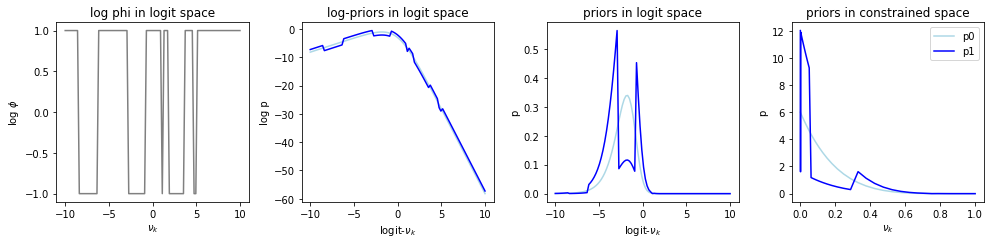

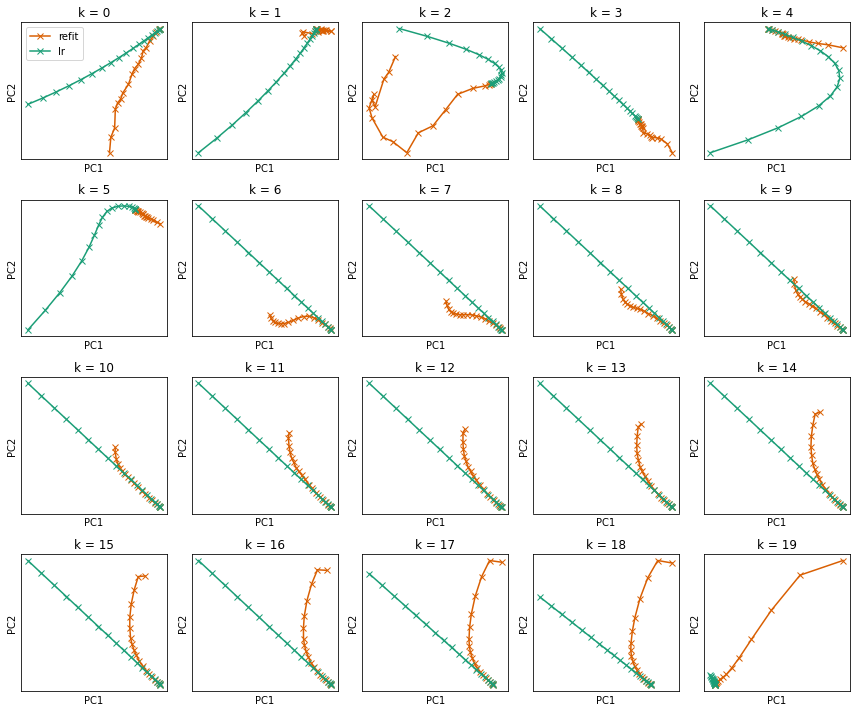

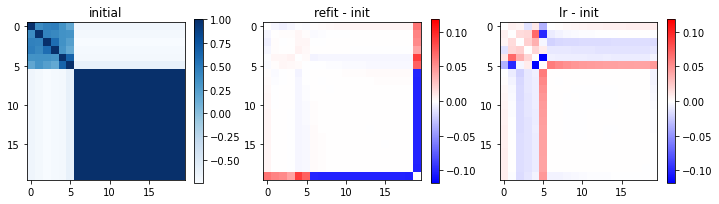

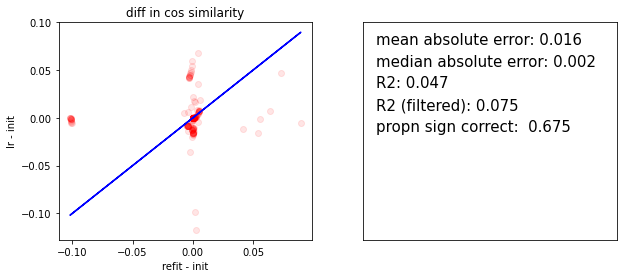

In [77]:
perturbation = 'worst_case'
plot_perturbation(perturbation)
plot_results_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(


Derivative time: 361.376secs
CG tolerance:  0.01
Optim time at epsilon = 1: 1222.676secs


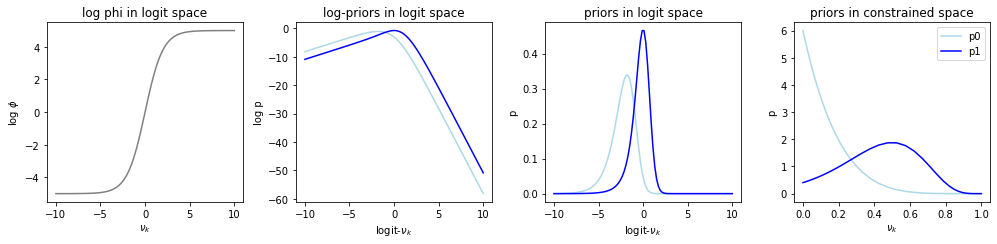

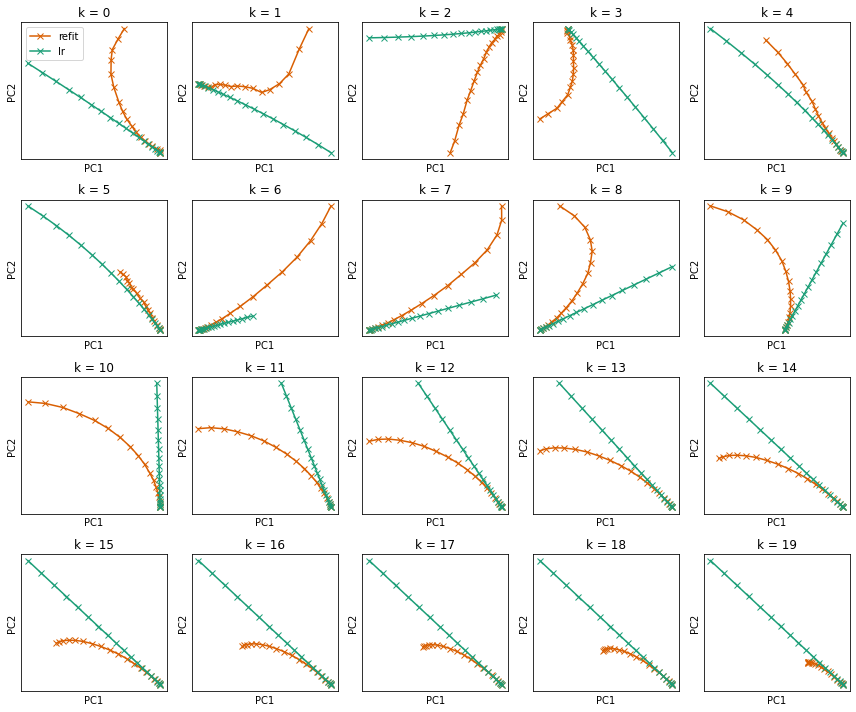

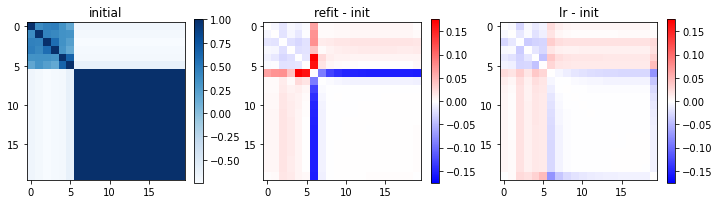

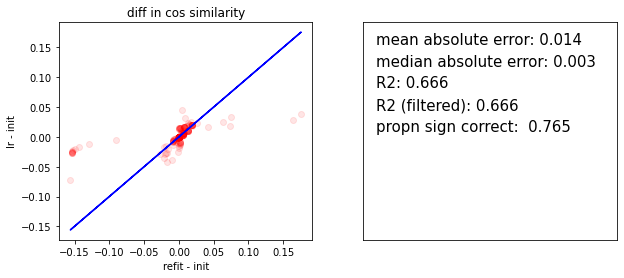

In [79]:
perturbation = 'sigmoidal'
plot_perturbation(perturbation)
plot_results_for_perturbation(perturbation)

Derivative time: 361.011secs
CG tolerance:  0.01
Optim time at epsilon = 1: 1293.163secs


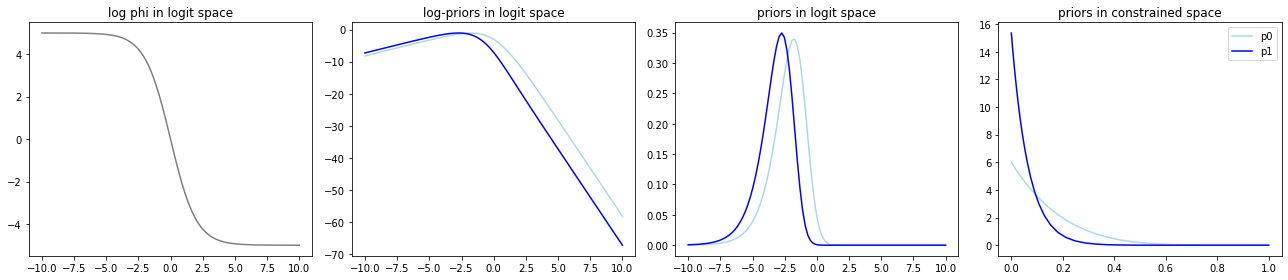

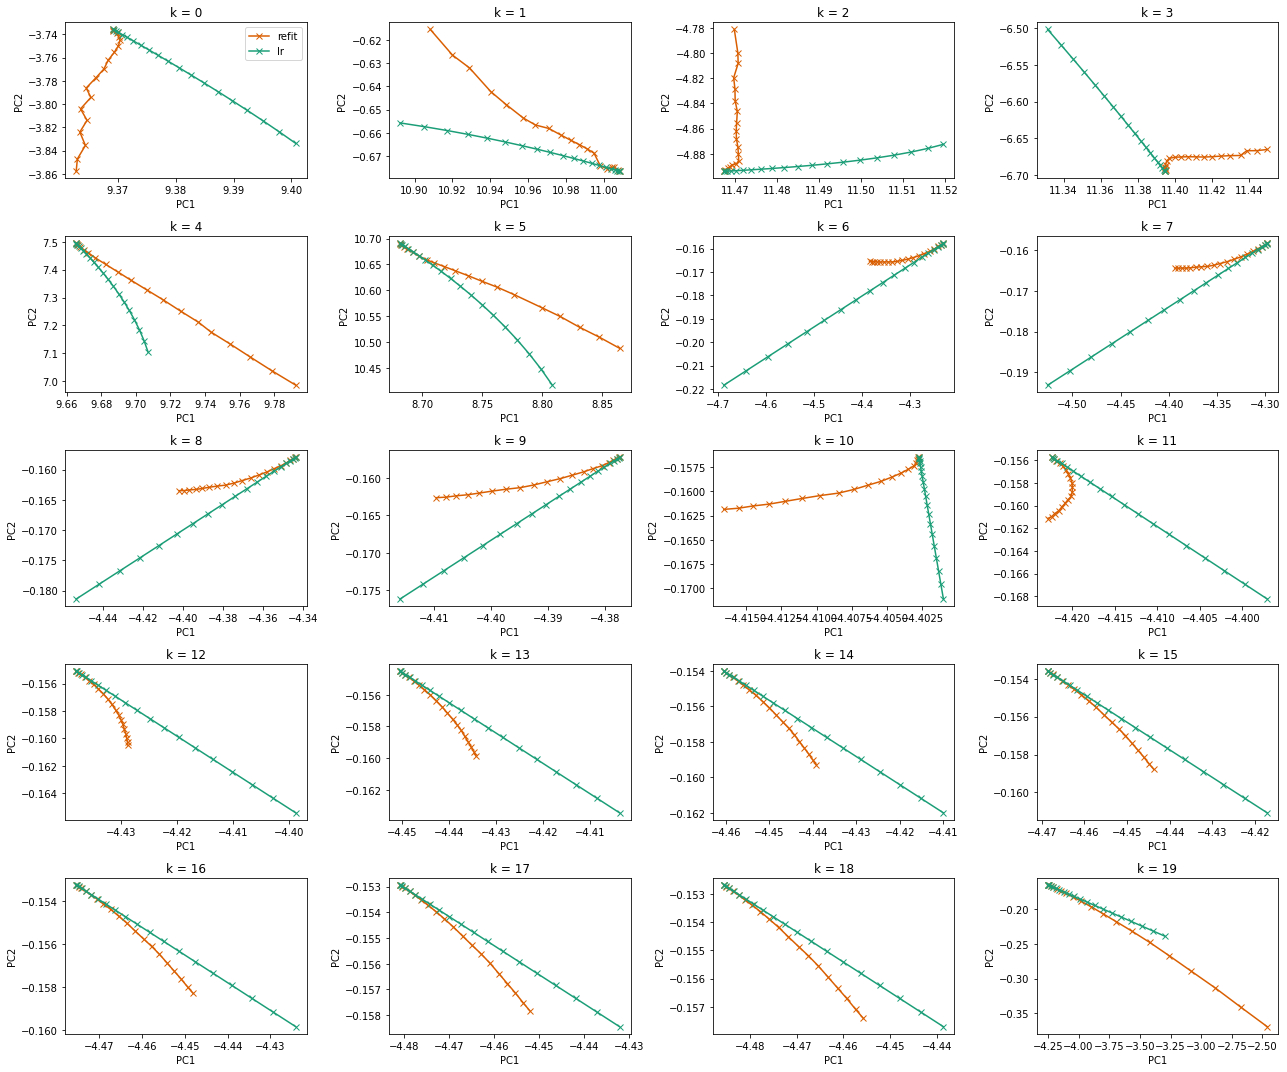

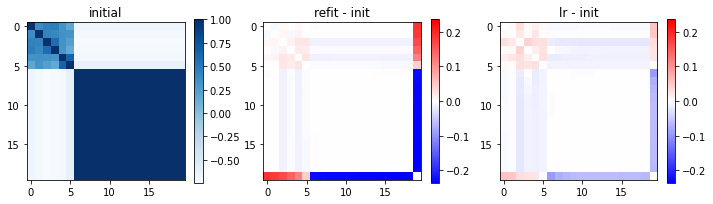

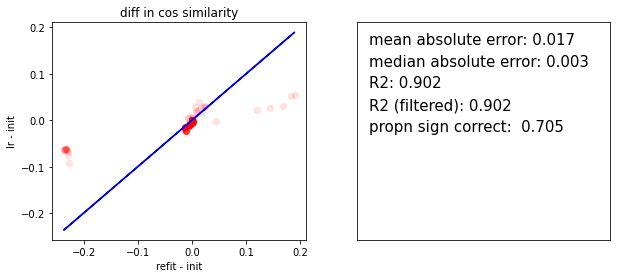

In [21]:
perturbation = 'sigmoidal_neg'
plot_perturbation(perturbation)
plot_results_for_perturbation(perturbation)

Derivative time: 203.557secs
CG tolerance:  0.01
Optim time at epsilon = 1: 956.758secs


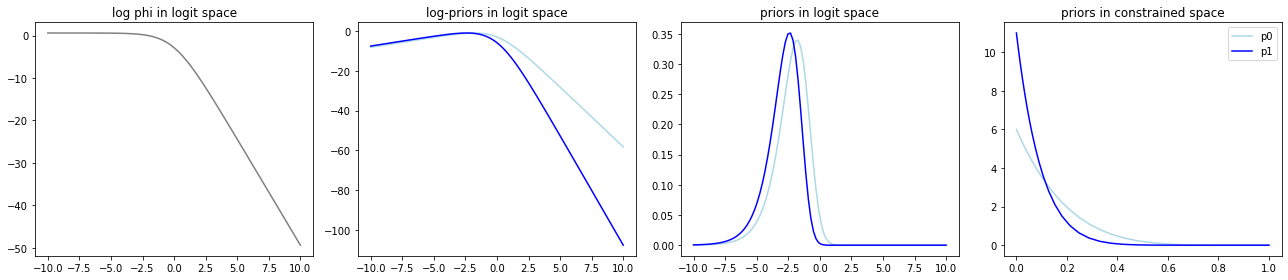

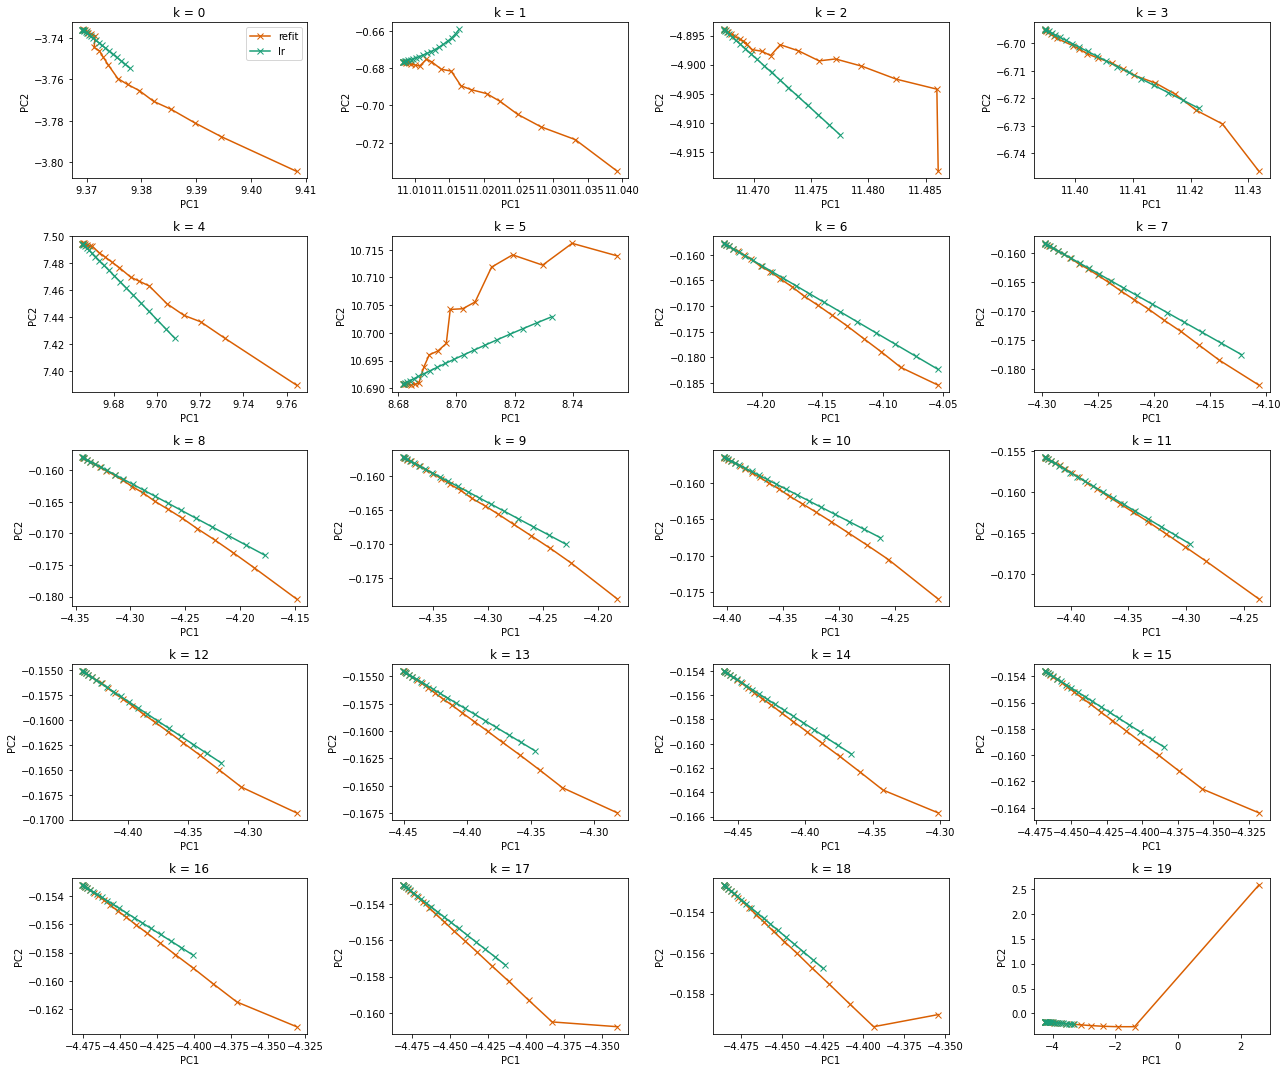

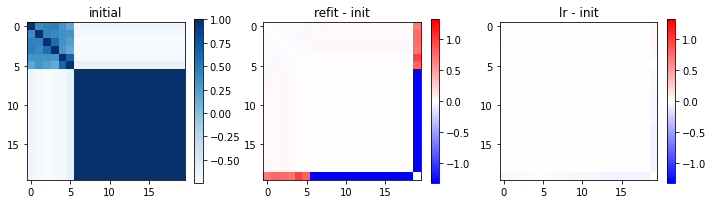

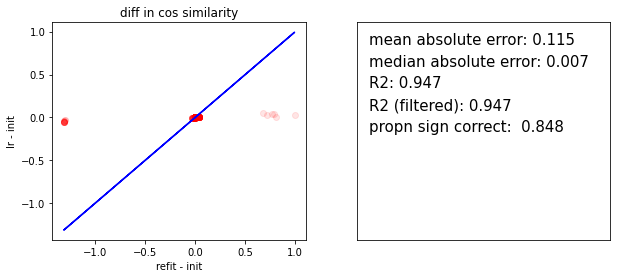

In [22]:
perturbation = 'alpha_pert_pos'
plot_perturbation(perturbation)
plot_results_for_perturbation(perturbation)

Derivative time: 204.619secs
CG tolerance:  0.01
Optim time at epsilon = 1: 3460.345secs


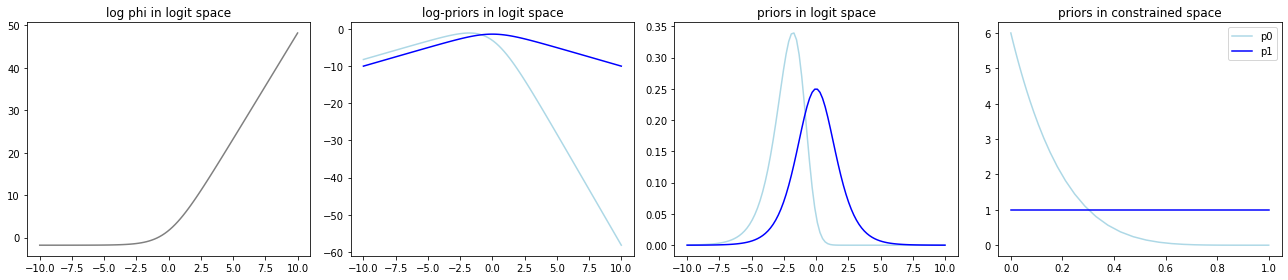

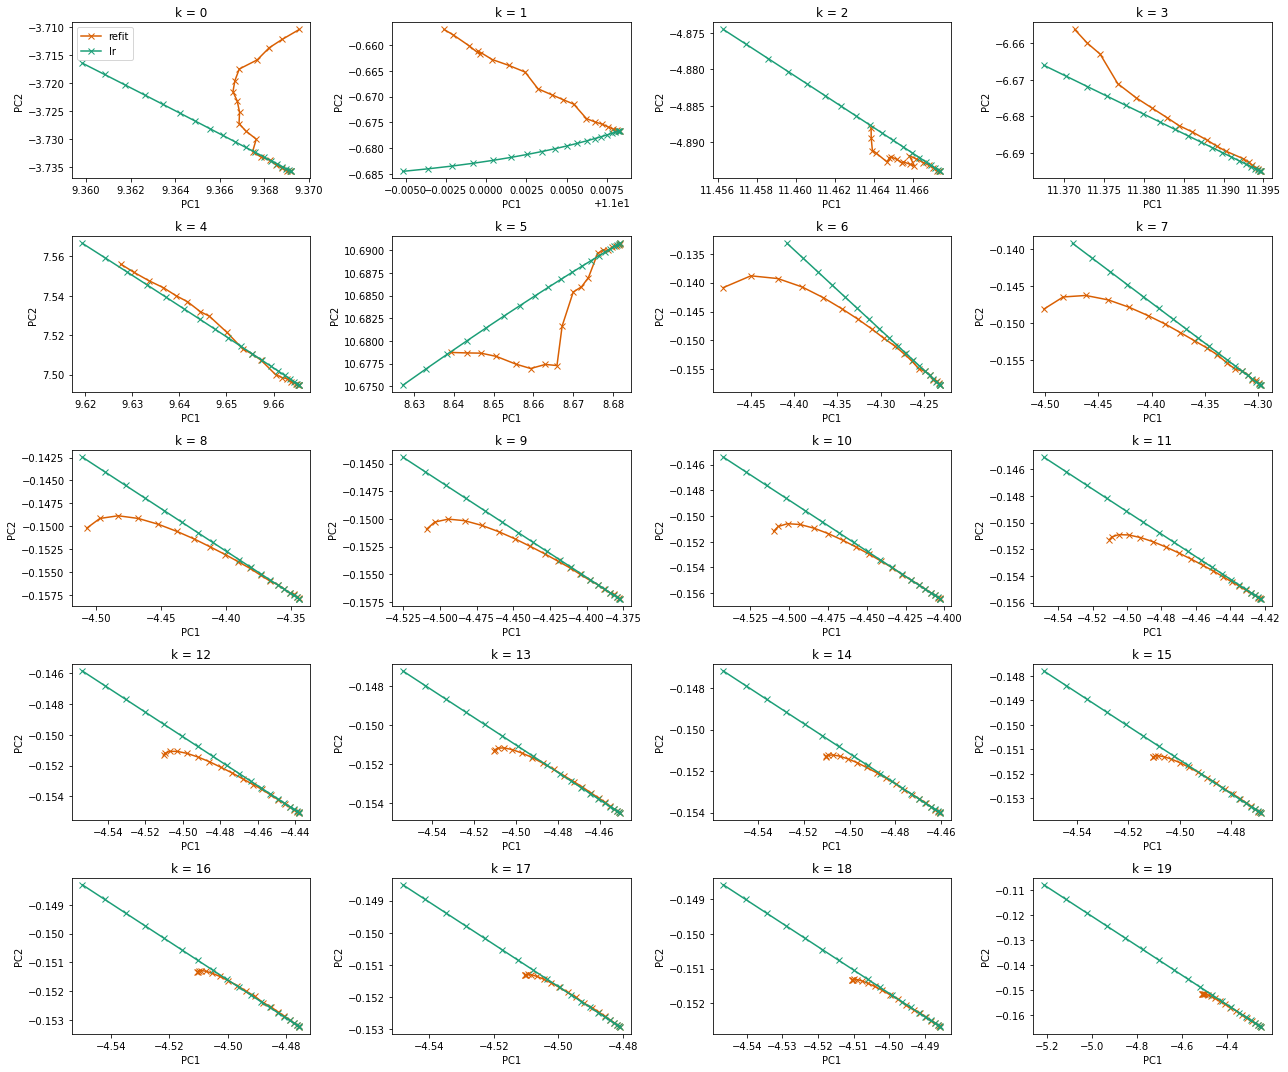

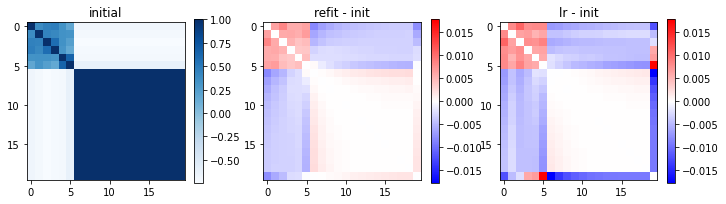

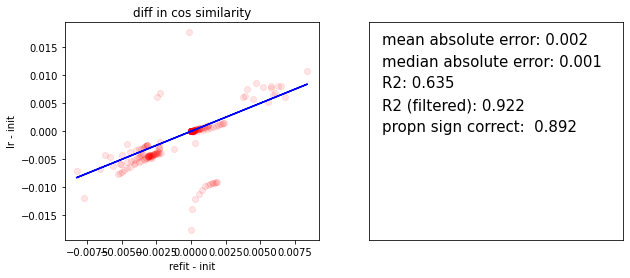

In [23]:
perturbation = 'alpha_pert_neg'
plot_perturbation(perturbation)
plot_results_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.091946e-08
  warnings.warn(


Derivative time: 249.059secs
CG tolerance:  0.01
Optim time at epsilon = 1: 682.865secs


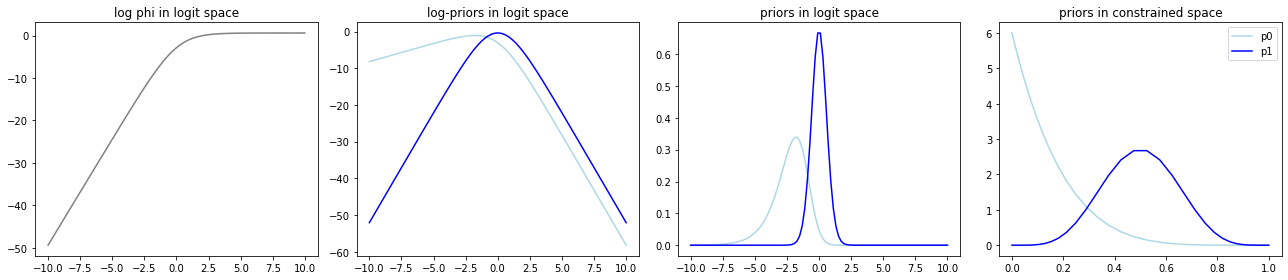

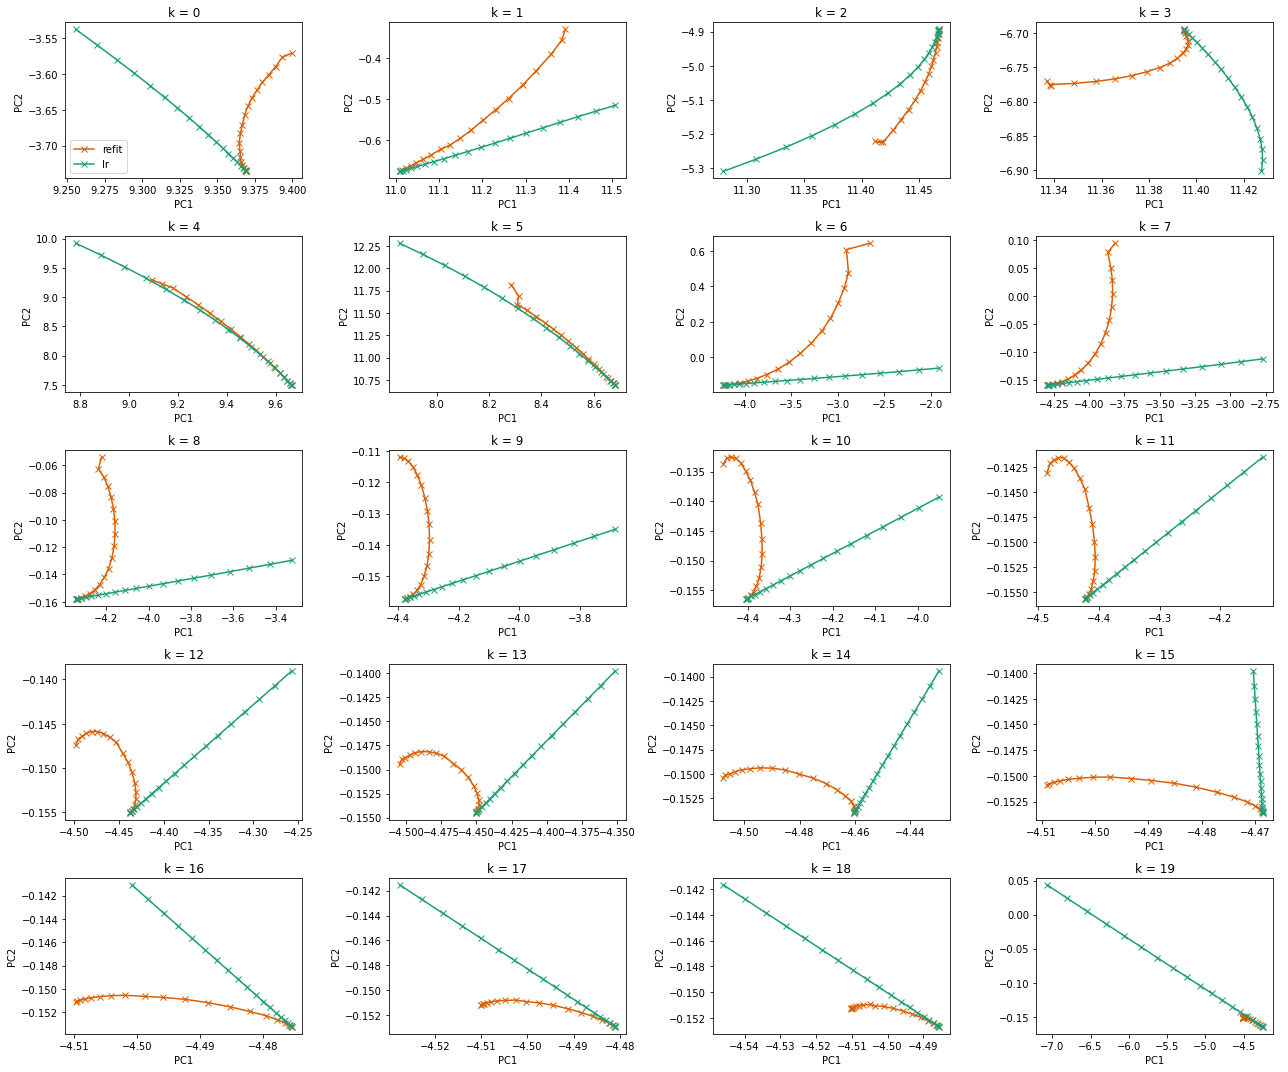

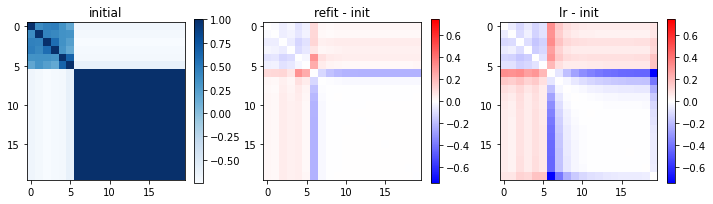

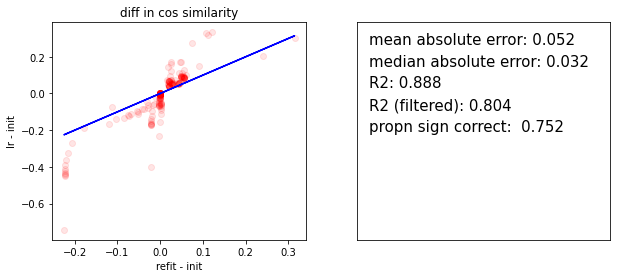

In [24]:
perturbation = 'alpha_pert_pos_xflip'
plot_perturbation(perturbation)
plot_results_for_perturbation(perturbation)

In [25]:
# perturbation = 'alpha_pert_neg_xflip'
# plot_perturbation(perturbation)
# plot_results_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.227507e-06
  warnings.warn(


Derivative time: 476.506secs
CG tolerance:  0.01
Optim time at epsilon = 1: 1406.211secs


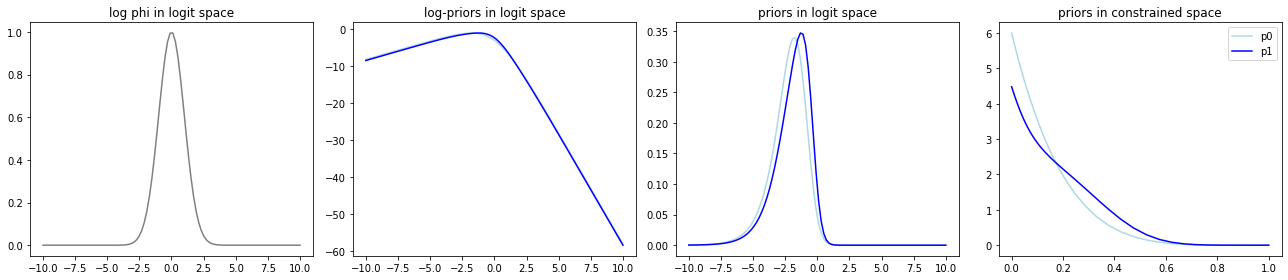

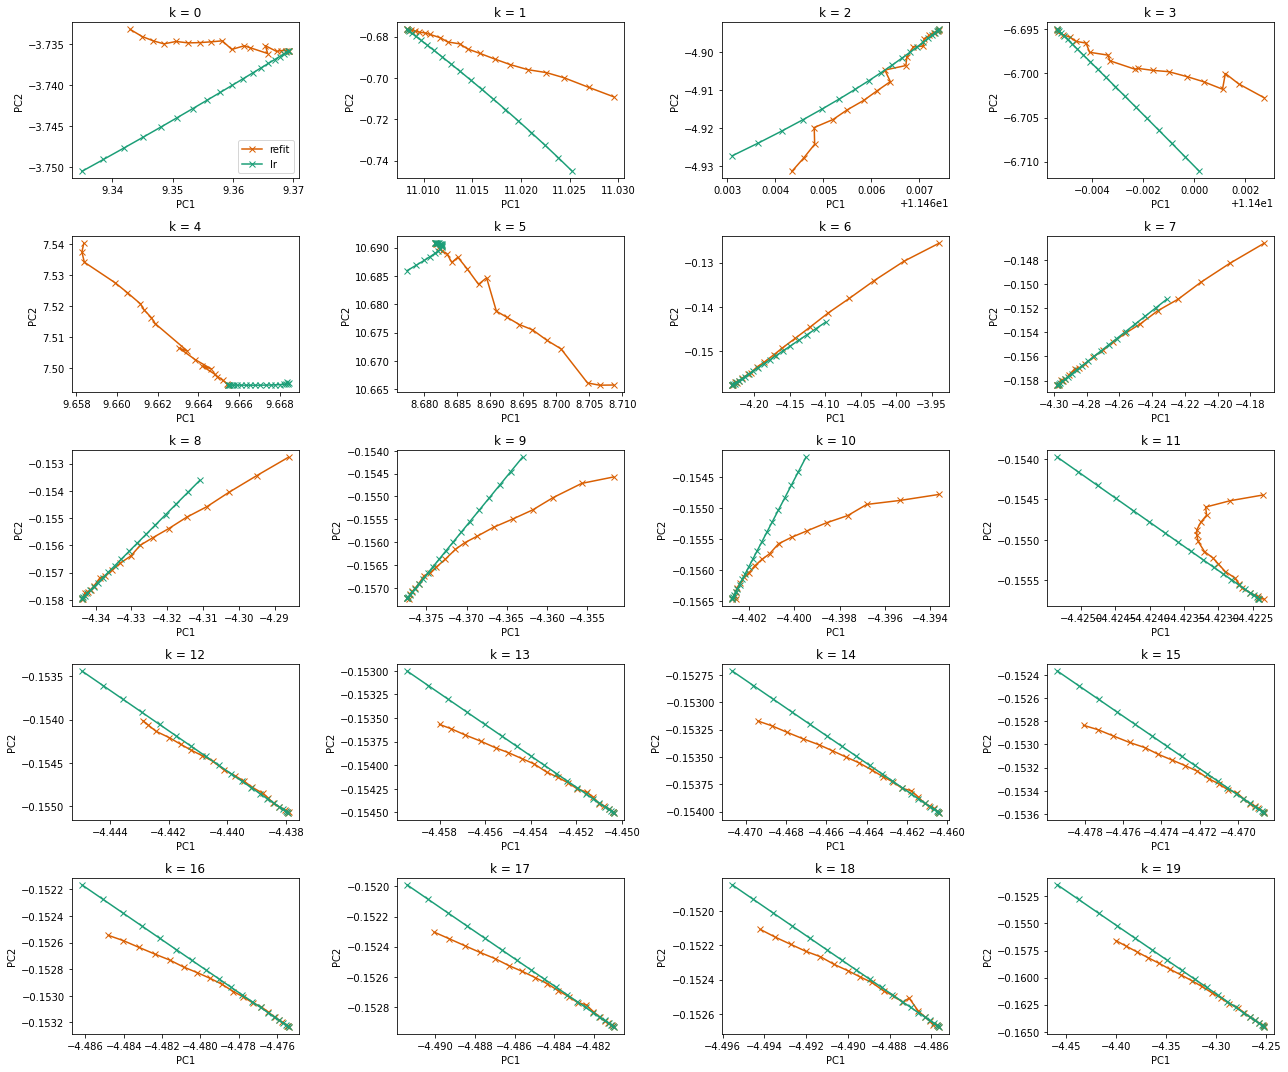

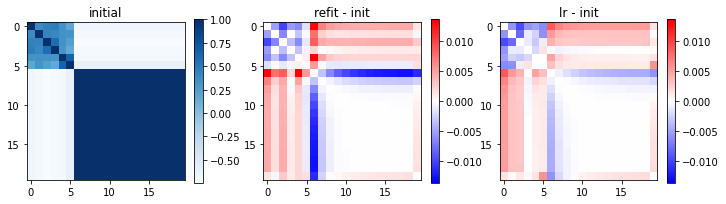

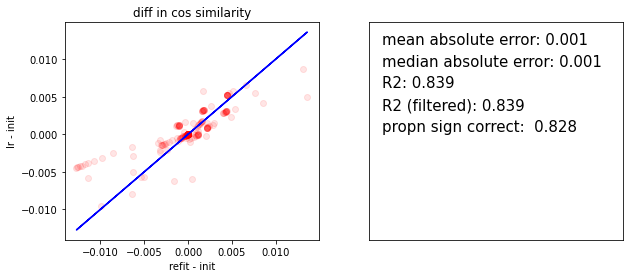

In [26]:
perturbation = 'gauss_pert1_pos'
plot_perturbation(perturbation)
plot_results_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.001209e-08
  warnings.warn(


Derivative time: 479.543secs
CG tolerance:  0.01
Optim time at epsilon = 1: 918.602secs


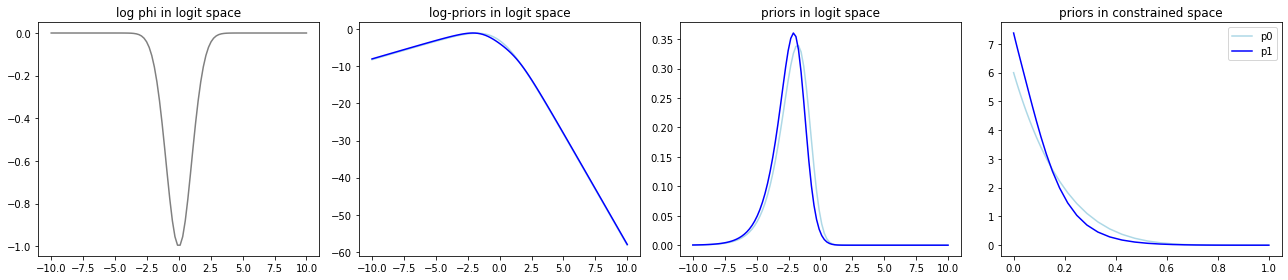

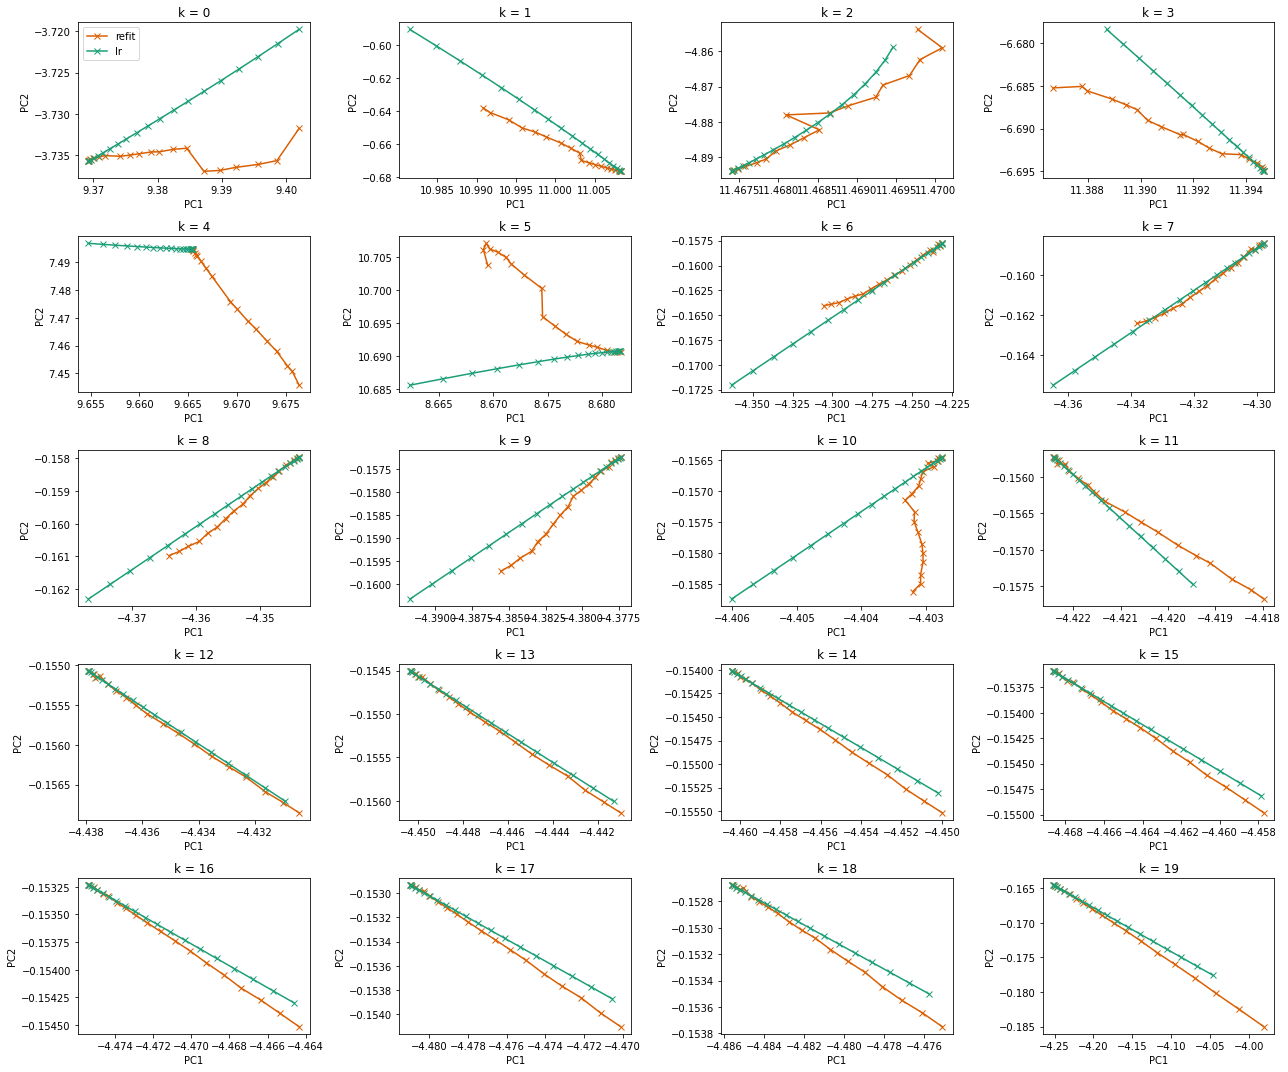

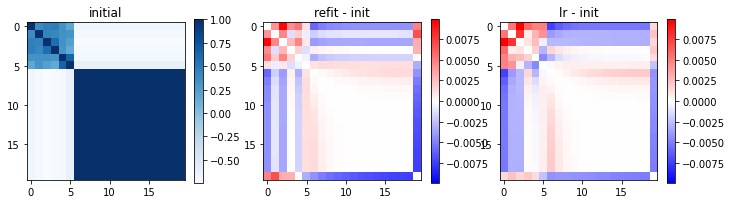

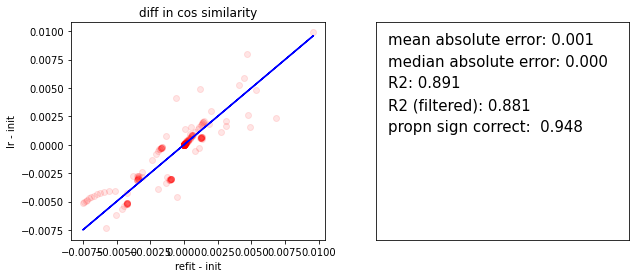

In [27]:
perturbation = 'gauss_pert1_neg'
plot_perturbation(perturbation)
plot_results_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.412626e-07
  warnings.warn(


Derivative time: 225.848secs
CG tolerance:  0.01
Optim time at epsilon = 1: 1488.035secs


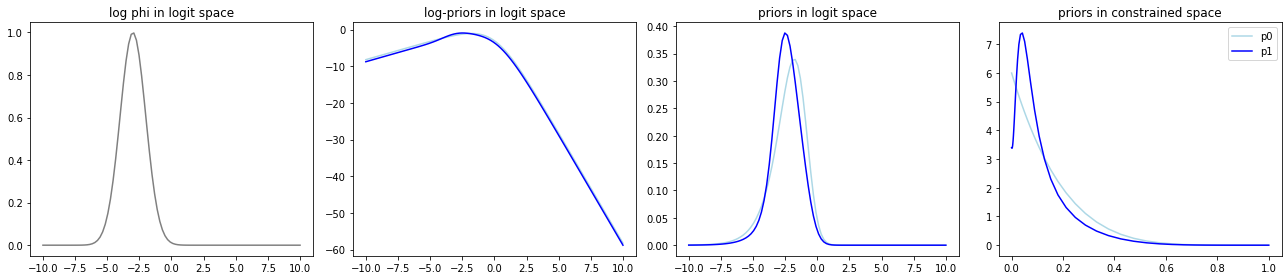

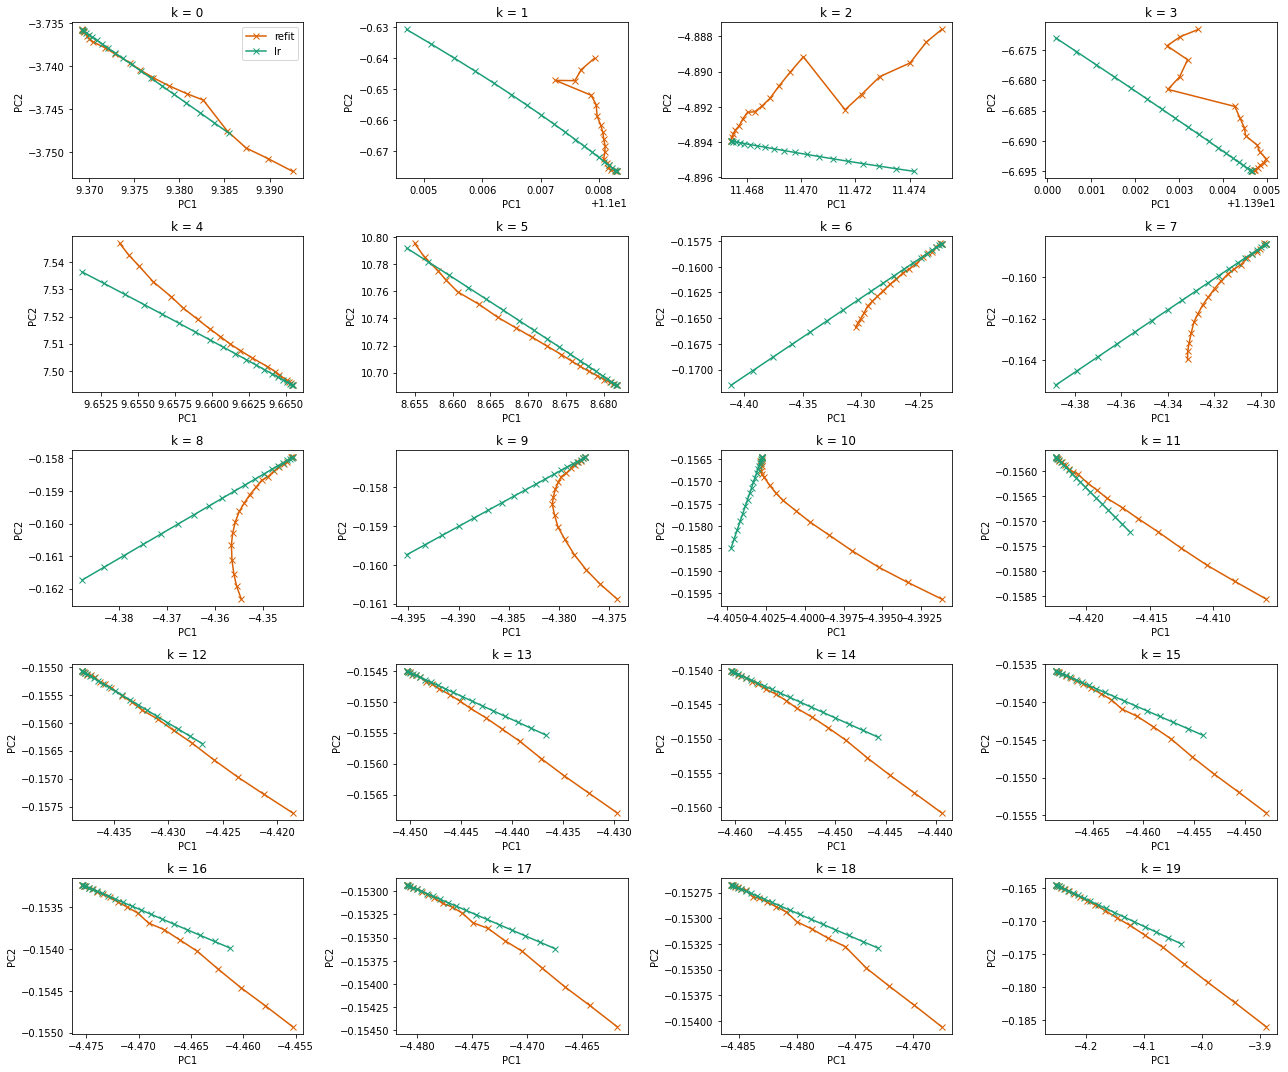

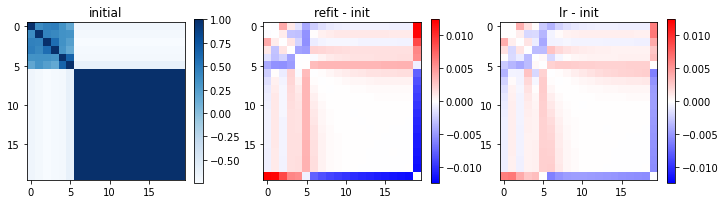

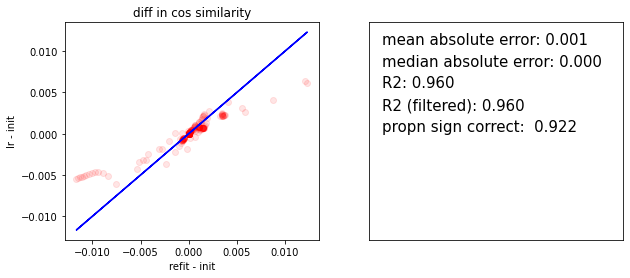

In [28]:
perturbation = 'gauss_pert2_pos'
plot_perturbation(perturbation)
plot_results_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.524900e-08
  warnings.warn(


Derivative time: 225.855secs
CG tolerance:  0.01
Optim time at epsilon = 1: 1210.528secs


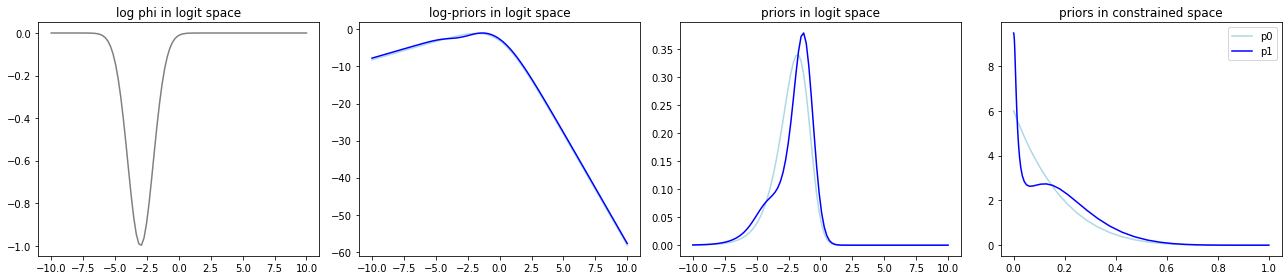

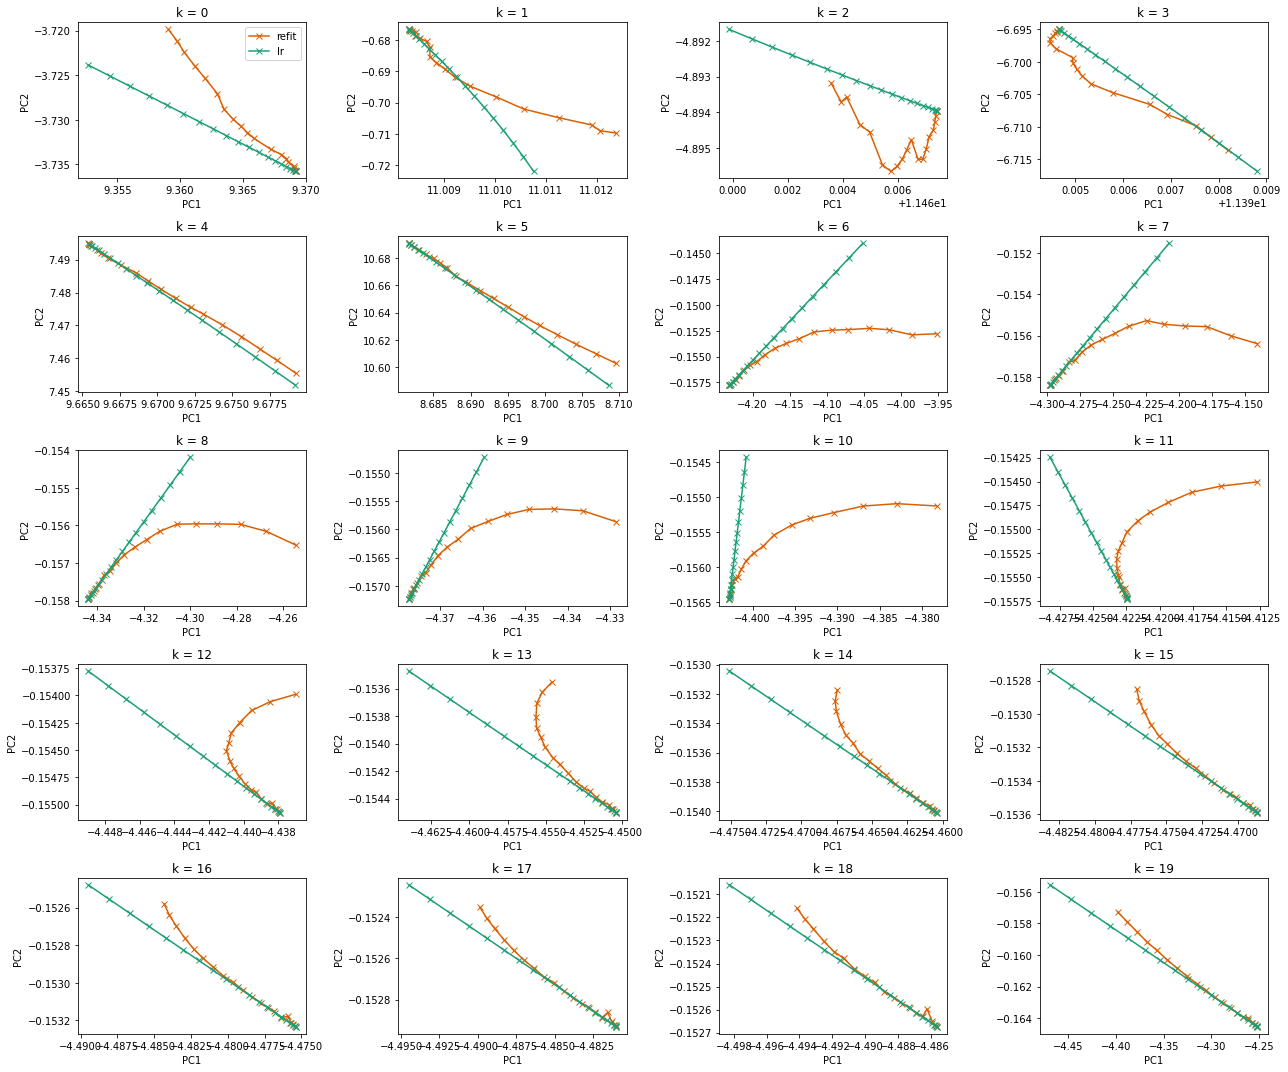

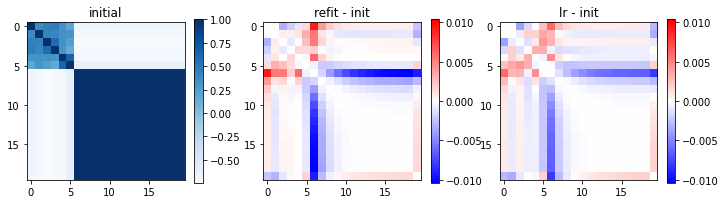

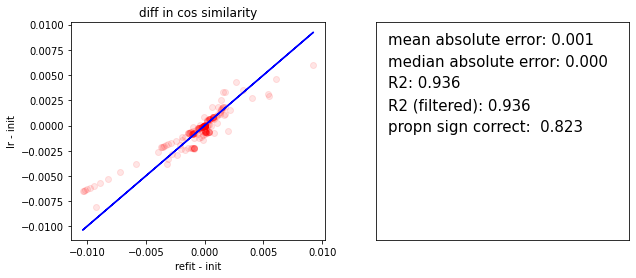

In [29]:
perturbation = 'gauss_pert2_neg'
plot_perturbation(perturbation)
plot_results_for_perturbation(perturbation)